# Stock Market Prediction using Numerical and Textual Analysis
## GRIP Dec 2020 Intern
## Naitik Rathod

In [2]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

Using TensorFlow backend.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\naiti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# reading the datasets into pandas
stock_price = pd.read_csv('BSESN.csv')

In [4]:
stock_headlines = pd.read_csv('india-news-headlines.csv')

In [5]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,03-01-2005,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,04-01-2005,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,05-01-2005,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,06-01-2005,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,07-01-2005,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0


In [6]:
len(stock_price), len(stock_headlines)

(3912, 3297172)

In [7]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

## Stock Prices

In [8]:
#dropping any null entries in our data
stock_price.dropna(axis=0, inplace=True)

In [9]:
# dropping duplicates in data
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2005-01-02,6552.470215,6565.209961,6586.250000,6508.990234,28400.0
2005-01-03,6651.080078,6725.919922,6725.919922,6628.220215,16800.0
2005-01-04,6605.040039,6506.600098,6618.080078,6468.520020,11400.0
2005-01-06,6729.899902,6729.390137,6763.279785,6710.370117,9800.0
2005-01-07,7210.770020,7165.450195,7228.569824,7154.930176,12600.0
...,...,...,...,...,...
2020-12-03,32778.140630,34472.500000,34472.500000,32493.099610,25200.0
2020-12-05,31371.119140,31342.929690,31536.890630,30844.660160,23100.0
2020-12-06,33780.890630,32436.689450,33856.269530,32348.099610,23000.0


## Stock Headlines

In [10]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-01,win over cena satisfying but defeating underta...
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
...,...
2020-06-26,Containment zone residents slam high prices ch...
2020-06-27,like me i wont let you have a toxic relationsh...
2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...


### Combining both Prices and Headlines

In [11]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2005-01-02,6552.470215,6565.209961,6586.250000,6508.990234,28400.0,Whatever. It's cool and happening. Reality TV ...
2005-01-03,6651.080078,6725.919922,6725.919922,6628.220215,16800.0,"ICAI compliments minister,Partnering for futur..."
2005-01-04,6605.040039,6506.600098,6618.080078,6468.520020,11400.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S..."
2005-01-06,6729.899902,6729.390137,6763.279785,6710.370117,9800.0,"Doon School preparing to admit girls?,Market M..."
2005-01-07,7210.770020,7165.450195,7228.569824,7154.930176,12600.0,"Faultline Repair,No Parade; Please,NRI Spirit,..."
...,...,...,...,...,...,...
2020-06-24,34868.980470,35679.738280,35706.550780,34794.929690,26600.0,I never thought I had a voice until today: Vid...
2020-06-25,34842.101560,34525.390630,35081.609380,34499.781250,24600.0,Truck firms look for new export markets to sel...
2020-06-26,35171.269530,35144.781250,35254.878910,34910.339840,24800.0,Containment zone residents slam high prices ch...
2020-06-29,34961.519530,34926.949220,35032.359380,34662.058590,18300.0,6 hot and stylish bikini looks of Katrina Kaif...


In [12]:
#Sentiment Analysis
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2005-01-02,6552.470215,6565.209961,6586.250000,6508.990234,28400.0,Whatever. It's cool and happening. Reality TV ...,,,,
2005-01-03,6651.080078,6725.919922,6725.919922,6628.220215,16800.0,"ICAI compliments minister,Partnering for futur...",,,,
2005-01-04,6605.040039,6506.600098,6618.080078,6468.520020,11400.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S...",,,,
2005-01-06,6729.899902,6729.390137,6763.279785,6710.370117,9800.0,"Doon School preparing to admit girls?,Market M...",,,,
2005-01-07,7210.770020,7165.450195,7228.569824,7154.930176,12600.0,"Faultline Repair,No Parade; Please,NRI Spirit,...",,,,


In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

stock_data.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2005-01-02,6552.470215,6565.209961,6586.250000,6508.990234,28400.0,Whatever. It's cool and happening. Reality TV ...,-0.9617,0.099,0.814,0.087
2005-01-03,6651.080078,6725.919922,6725.919922,6628.220215,16800.0,"ICAI compliments minister,Partnering for futur...",-0.9731,0.114,0.802,0.084
2005-01-04,6605.040039,6506.600098,6618.080078,6468.520020,11400.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S...",-0.7600,0.062,0.880,0.059
2005-01-06,6729.899902,6729.390137,6763.279785,6710.370117,9800.0,"Doon School preparing to admit girls?,Market M...",0.9417,0.073,0.825,0.102
2005-01-07,7210.770020,7165.450195,7228.569824,7154.930176,12600.0,"Faultline Repair,No Parade; Please,NRI Spirit,...",-0.9456,0.087,0.836,0.076


In [15]:
# dropping unwanted 'headline_text' and rearranging columns
stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-02,6552.470215,-0.9617,0.099,0.814,0.087,6565.209961,6586.250000,6508.990234,28400.0
2005-01-03,6651.080078,-0.9731,0.114,0.802,0.084,6725.919922,6725.919922,6628.220215,16800.0
2005-01-04,6605.040039,-0.7600,0.062,0.880,0.059,6506.600098,6618.080078,6468.520020,11400.0
2005-01-06,6729.899902,0.9417,0.073,0.825,0.102,6729.390137,6763.279785,6710.370117,9800.0
2005-01-07,7210.770020,-0.9456,0.087,0.836,0.076,7165.450195,7228.569824,7154.930176,12600.0


## Feature engineering of the Combined Data

In [16]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [17]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,3789.000000,3789.000000,3789.000000,3789.000000,3789.000000,3789.000000,3789.000000,3789.000000,3.789000e+03
mean,21663.645004,-0.895219,0.128772,0.783644,0.087604,21687.868092,21816.472587,21517.159211,1.008542e+05
std,9071.122104,0.420928,0.021369,0.027166,0.016079,9088.818264,9104.429005,9047.147781,1.215166e+06
min,6102.740234,-1.000000,0.038000,0.635000,0.029000,6093.660156,6174.000000,6069.330078,8.000000e+02
25%,15422.049810,-0.999800,0.116000,0.765000,0.077000,15440.099610,15579.780270,15314.019530,1.060000e+04
50%,19345.699220,-0.999500,0.129000,0.781000,0.087000,19364.609380,19478.009770,19218.130860,1.440000e+04
75%,28077.000000,-0.997100,0.143000,0.799000,0.097000,28093.539060,28205.710940,27919.890630,2.020000e+04
max,41952.628910,1.000000,0.217000,0.900000,0.253000,42263.000000,42273.871090,41850.289060,3.181510e+07


In [18]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3789 entries, 2005-01-02 to 2020-06-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     3789 non-null   float64
 1   compound  3789 non-null   float64
 2   negative  3789 non-null   float64
 3   neutral   3789 non-null   float64
 4   positive  3789 non-null   float64
 5   Open      3789 non-null   float64
 6   High      3789 non-null   float64
 7   Low       3789 non-null   float64
 8   Volume    3789 non-null   float64
dtypes: float64(9)
memory usage: 296.0 KB


## Stock Data Analysis

Text(0, 0.5, 'Close Price (INR)')

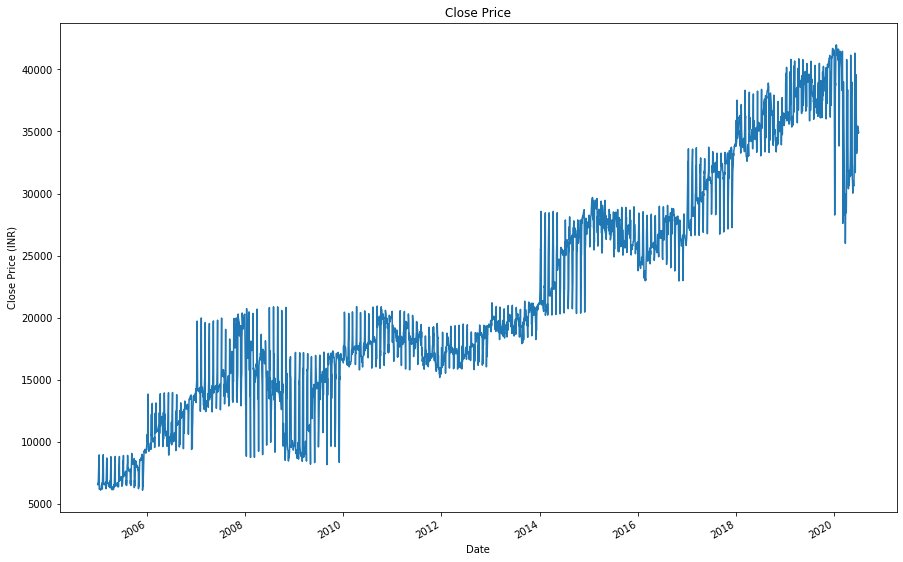

In [19]:
#Setting plot size and labels
plt.figure(figsize=(15,10))

stock_data['Close'].plot()


plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [20]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-09,7042.122907,-0.387843,0.094857,0.813571,0.091714,7020.497140,7072.199916,6983.810128,14857.142857
2005-01-12,7383.881487,-0.386857,0.096000,0.812143,0.092000,7341.727190,7411.322824,7306.748605,13400.000000
2005-01-13,7322.450056,-0.319457,0.093857,0.811714,0.094571,7257.745745,7342.327148,7236.724261,13885.714286
2005-01-14,7260.847168,-0.099314,0.092714,0.812000,0.095286,7218.577149,7289.657157,7190.375697,14857.142857


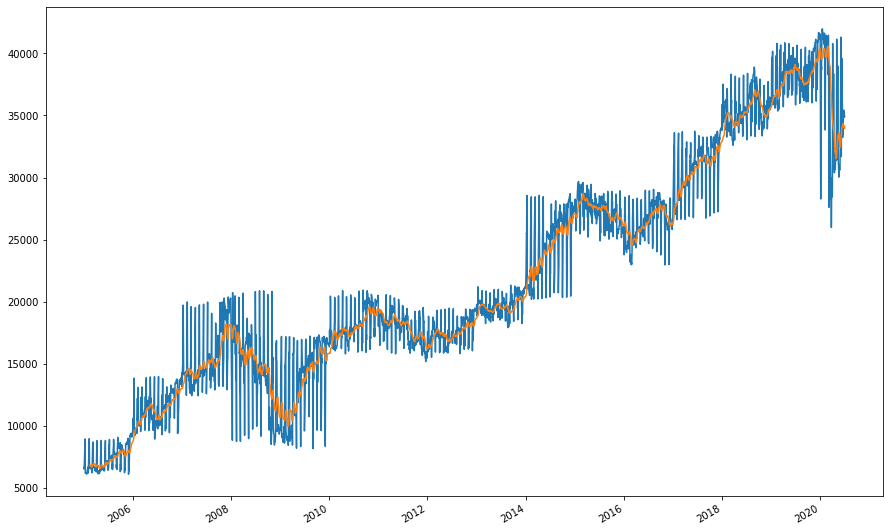

In [21]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [22]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-02,6552.470215,-0.9617,0.099,0.814,0.087,6565.209961,6586.250000,6508.990234,28400.0
2005-01-03,6651.080078,-0.9731,0.114,0.802,0.084,6725.919922,6725.919922,6628.220215,16800.0
2005-01-04,6605.040039,-0.7600,0.062,0.880,0.059,6506.600098,6618.080078,6468.520020,11400.0
2005-01-06,6729.899902,0.9417,0.073,0.825,0.102,6729.390137,6763.279785,6710.370117,9800.0
2005-01-07,7210.770020,-0.9456,0.087,0.836,0.076,7165.450195,7228.569824,7154.930176,12600.0
...,...,...,...,...,...,...,...,...,...
2020-06-24,34868.980470,-0.9997,0.115,0.811,0.074,35679.738280,35706.550780,34794.929690,26600.0
2020-06-25,34842.101560,-0.9999,0.126,0.820,0.054,34525.390630,35081.609380,34499.781250,24600.0
2020-06-26,35171.269530,-0.9999,0.149,0.766,0.085,35144.781250,35254.878910,34910.339840,24800.0
2020-06-29,34961.519530,-0.9997,0.119,0.804,0.078,34926.949220,35032.359380,34662.058590,18300.0


## DATA FOR MODELLING

In [23]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3030
Number of records in Test Data: 759


In [24]:
# predicting one step ahead
steps_to_predict = 1


close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2005-01-03     6651.080078
2005-01-04     6605.040039
2005-01-06     6729.899902
2005-01-07     7210.770020
2005-01-08     7669.450195
                  ...     
2020-06-24    34868.980470
2020-06-25    34842.101560
2020-06-26    35171.269530
2020-06-29    34961.519530
2020-06-30    34915.800780
Name: Close, Length: 3788, dtype: float64

In [25]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2005-01-03,6651.080078,6605.040039,-0.9731,-0.7600,16800.0,6725.919922,6725.919922,6628.220215
2005-01-04,6605.040039,6729.899902,-0.7600,0.9417,11400.0,6506.600098,6618.080078,6468.520020
2005-01-06,6729.899902,7210.770020,0.9417,-0.9456,9800.0,6729.390137,6763.279785,6710.370117
2005-01-07,7210.770020,7669.450195,-0.9456,0.9720,12600.0,7165.450195,7228.569824,7154.930176
2005-01-08,7669.450195,7876.149902,0.9720,-0.9882,13800.0,7632.009766,7681.109863,7596.740234
2005-01-09,7876.149902,8944.780273,-0.9882,-0.9548,11200.0,7818.899902,7902.189941,7818.899902
2005-01-12,8944.780273,6221.060059,-0.9548,-0.5013,18200.0,8813.820313,8960.110352,8769.559570
2005-01-13,6221.060059,6173.819824,-0.5013,0.7810,20200.0,6138.049805,6242.950195,6138.049805
2005-01-14,6173.819824,6194.069824,0.7810,-0.9925,18200.0,6232.419922,6249.390137,6144.080078
2005-01-17,6194.069824,6192.350098,-0.9925,-0.9990,19000.0,6202.740234,6232.970215,6087.549805


In [26]:
#close price shifted set as the target var
y = data['close_price_shifted']
y

2005-01-03     6605.040039
2005-01-04     6729.899902
2005-01-06     7210.770020
2005-01-07     7669.450195
2005-01-08     7876.149902
                  ...     
2020-06-23    34868.980470
2020-06-24    34842.101560
2020-06-25    35171.269530
2020-06-26    34961.519530
2020-06-29    34915.800780
Name: close_price_shifted, Length: 3787, dtype: float64

In [27]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2005-01-03,6651.080078,-0.9731,-0.7600,16800.0,6725.919922,6725.919922,6628.220215
2005-01-04,6605.040039,-0.7600,0.9417,11400.0,6506.600098,6618.080078,6468.520020
2005-01-06,6729.899902,0.9417,-0.9456,9800.0,6729.390137,6763.279785,6710.370117
2005-01-07,7210.770020,-0.9456,0.9720,12600.0,7165.450195,7228.569824,7154.930176
2005-01-08,7669.450195,0.9720,-0.9882,13800.0,7632.009766,7681.109863,7596.740234
...,...,...,...,...,...,...,...
2020-06-23,35430.429690,-0.9999,-0.9997,25200.0,35015.730470,35482.160160,34843.691410
2020-06-24,34868.980470,-0.9997,-0.9999,26600.0,35679.738280,35706.550780,34794.929690
2020-06-25,34842.101560,-0.9999,-0.9999,24600.0,34525.390630,35081.609380,34499.781250
2020-06-26,35171.269530,-0.9999,-0.9997,24800.0,35144.781250,35254.878910,34910.339840


In [28]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.96940912, -0.9731    , -0.76      , ..., -0.96503891,
         -0.96942261, -0.96876047],
        [-0.97197761, -0.76      ,  0.9417    , ..., -0.9771663 ,
         -0.97539714, -0.97768702],
        [-0.9650119 ,  0.9417    , -0.9456    , ..., -0.96484702,
         -0.9673528 , -0.96416865],
        ...,
        [ 0.60331663, -0.9999    , -0.9999    , ...,  0.57214539,
          0.60153532,  0.58913858],
        [ 0.62168031, -0.9999    , -0.9997    , ...,  0.60639488,
          0.61113478,  0.61208702],
        [ 0.60997874, -0.9997    , -0.9998    , ...,  0.59434976,
          0.59880678,  0.59820918]]),
 array([[-0.97197761],
        [-0.9650119 ],
        [-0.93818504],
        ...,
        [ 0.62168031],
        [ 0.60997874],
        [ 0.60742817]]))

## Data divided for training and test datasets

In [29]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training set X: (3030, 7) and y: (3030, 1)
Number of rows and columns in Test set X: (756, 7) and y: (756, 1)


In [51]:
#reshaping dataset

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3030, 7, 1, 1, 1)
Shape of Test set X: (756, 7, 1, 1, 1)


## Data Modelling

In [32]:
# seed set to achieve consistent and less random predictions
np.random.seed(2016)

# setting the architecture for the data model
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 100)            40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [53]:
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, batch_size=8, epochs=10, verbose=1)

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (7, 1, 1, 1)